# Rainfalls in Navarcles

**Goal**

**Objective**  

**Data description**  


In [1]:
# import libraries 
import os
import warnings

import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from matplotlib.colors import LinearSegmentedColormap

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_validate, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from pmdarima import auto_arima
from prophet import Prophet
from pyod.models.knn import KNN

warnings.filterwarnings("ignore")

In [2]:
# font sizes
params = {'figure.titlesize': 18,
          'axes.titlesize':   16,
          'axes.labelsize':   14,
          'font.size': 14,
          'legend.fontsize':  12,
          'xtick.labelsize':  12,
          'ytick.labelsize':  12}
plt.rcParams.update(params)

# plt.style.use
sns.set_style("darkgrid")

In [3]:
# set random state
RANDOM_STATE = 42

## Data Load
### Navarcles manual

In [4]:
data = pd.read_excel('rain_navarcles_1995-2024.xlsx', na_values=["NA"], keep_default_na=False)
data

,Unnamed: 0,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,2020-01-01,,,,7,6,,,2,NaN,...,,,NaN,,,,,,,
1,2020-01-02,,,9,,,,,3,NaN,...,,2,NaN,,,,,,,
2,2020-01-03,,,24,,,,,2,NaN,...,,,NaN,,,,,,,
3,2020-01-04,,,,,,,,,NaN,...,,,NaN,,,,,,,
4,2020-01-05,,3,,,,,,,NaN,...,,,NaN,,,,,1,,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,2020-12-27,,,,,,NaN,,NaN,,...,,NaN,2,,,,,,,
362,2020-12-28,,,,,,NaN,,NaN,,...,,NaN,,,,,,,,
363,2020-12-29,,,,,,NaN,,NaN,,...,,NaN,,,,,,,,
364,2020-12-30,3,,,,,NaN,,NaN,,...,,NaN,,,,,,,,


In [5]:
data = data.replace('',0).rename(columns={data.columns[0]: 'date'})
data["date"] = data['date'].dt.strftime("%m-%d")
data

,date,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,01-01,0.0,0.0,0.0,7.0,6.0,0.0,0,2.0,NaN,...,0,0.0,NaN,0.0,0,0.0,0.0,0.0,0.0,0.0
1,01-02,0.0,0.0,9.0,0.0,0.0,0.0,0,3.0,NaN,...,0,2.0,NaN,0.0,0,0.0,0.0,0.0,0.0,0.0
2,01-03,0.0,0.0,24.0,0.0,0.0,0.0,0,2.0,NaN,...,0,0.0,NaN,0.0,0,0.0,0.0,0.0,0.0,0.0
3,01-04,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,NaN,...,0,0.0,NaN,0.0,0,0.0,0.0,0.0,0.0,0.0
4,01-05,0.0,3.0,0.0,0.0,0.0,0.0,0,0.0,NaN,...,0,0.0,NaN,0.0,0,0.0,0.0,1.0,0.0,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,12-27,0.0,0.0,0.0,0.0,0.0,NaN,0,NaN,0.0,...,0,NaN,2.0,0.0,0,0.0,0.0,0.0,0.0,0.0
362,12-28,0.0,0.0,0.0,0.0,0.0,NaN,0,NaN,0.0,...,0,NaN,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
363,12-29,0.0,0.0,0.0,0.0,0.0,NaN,0,NaN,0.0,...,0,NaN,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
364,12-30,3.0,0.0,0.0,0.0,0.0,NaN,0,NaN,0.0,...,0,NaN,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0


#### Reshape data

In [6]:
# reshape data to long format
data_long = data.melt(id_vars=["date"], var_name="year", value_name="rainfall")

In [7]:
# create full date column
data_long["full_date"] = pd.to_datetime(
    data_long["year"].astype(str) + "-" + data_long["date"], 
    format="%Y-%m-%d",
    errors="coerce"
)
data_long

,date,year,rainfall,full_date
0,01-01,1995,0.0,1995-01-01
1,01-02,1995,0.0,1995-01-02
2,01-03,1995,0.0,1995-01-03
3,01-04,1995,0.0,1995-01-04
4,01-05,1995,0.0,1995-01-05
...,...,...,...,...
10975,12-27,2024,0.0,2024-12-27
10976,12-28,2024,0.0,2024-12-28
10977,12-29,2024,0.0,2024-12-29
10978,12-30,2024,0.0,2024-12-30


In [8]:
data_long.query('full_date.isna()')

,date,year,rainfall,full_date
59,02-29,1995,0.0,NaT
791,02-29,1997,0.0,NaT
1157,02-29,1998,0.0,NaT
1523,02-29,1999,0.0,NaT
2255,02-29,2001,0.0,NaT
2621,02-29,2002,0.0,NaT
2987,02-29,2003,NaN,NaT
3719,02-29,2005,0.0,NaT
4085,02-29,2006,0.0,NaT
4451,02-29,2007,0.0,NaT


In [9]:
# drop February 29 for non-leap years
data_long = (data_long
             .dropna(subset=["full_date"])
             .reset_index(drop=True)
            )             

In [10]:
# drop day and year columns, set full date as index
df = (data_long.drop(columns=["date", "year"])
               .set_index('full_date')
     )
print(df.info())
print()
print('\033[1mPercentage of NaN\033[0m')
print(f'{df["rainfall"].isna().mean():.2%}')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10958 entries, 1995-01-01 to 2024-12-31
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   rainfall  10280 non-null  float64
dtypes: float64(1)
memory usage: 171.2 KB
None

Percentage of NaN
6.19%


In [11]:
# check for monotonicity
if df.index.is_monotonic_increasing:
    print('The data is arranged in chronological order')
else:
    print('Dates are repeated or mixed up')

The data is arranged in chronological order


### Manresa AEMET

https://www.meteo.cat/wpweb/climatologia/dades-i-productes-climatics/series-climatiques-des-de-1950/

In [12]:
data_manresa = pd.read_csv('manresa_1950-2023.txt', sep="\s+", encoding = 'unicode_escape', header=11)
data_manresa

,ANY,MES,DIA,PPT,TX,TN,INS
0,1950,1,1,0.6,11.1,4.3,-99.9
1,1950,1,2,0.0,10.5,0.8,-99.9
2,1950,1,3,0.0,12.7,0.8,-99.9
3,1950,1,4,0.0,11.8,3.8,-99.9
4,1950,1,5,0.0,13.9,0.8,-99.9
...,...,...,...,...,...,...,...
27023,2023,12,27,0.0,15.1,-3.2,7.2
27024,2023,12,28,0.0,5.8,-4.1,0.2
27025,2023,12,29,0.0,11.0,-0.4,0.8
27026,2023,12,30,0.0,15.5,-0.3,7.3


In [13]:
df_manresa = (data_manresa
              #.drop(columns=['TX', 'TN', 'INS'])
              .set_axis(
                  ['year', 'month', 'day', 'rainfall', 't_max', 't_min', 'insolation'], axis=1))
df_manresa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27028 entries, 0 to 27027
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        27028 non-null  int64  
 1   month       27028 non-null  int64  
 2   day         27028 non-null  int64  
 3   rainfall    27028 non-null  float64
 4   t_max       27028 non-null  float64
 5   t_min       27028 non-null  float64
 6   insolation  27028 non-null  float64
dtypes: float64(4), int64(3)
memory usage: 1.4 MB


In [14]:
df_manresa['full_date'] = pd.to_datetime(
    df_manresa['year'].astype(str) + '-' + 
    df_manresa['month'].astype(str) + '-'+ 
    df_manresa['day'].astype(str)
)
df_manresa

,year,month,day,rainfall,t_max,t_min,insolation,full_date
0,1950,1,1,0.6,11.1,4.3,-99.9,1950-01-01
1,1950,1,2,0.0,10.5,0.8,-99.9,1950-01-02
2,1950,1,3,0.0,12.7,0.8,-99.9,1950-01-03
3,1950,1,4,0.0,11.8,3.8,-99.9,1950-01-04
4,1950,1,5,0.0,13.9,0.8,-99.9,1950-01-05
...,...,...,...,...,...,...,...,...
27023,2023,12,27,0.0,15.1,-3.2,7.2,2023-12-27
27024,2023,12,28,0.0,5.8,-4.1,0.2,2023-12-28
27025,2023,12,29,0.0,11.0,-0.4,0.8,2023-12-29
27026,2023,12,30,0.0,15.5,-0.3,7.3,2023-12-30


In [15]:
df_manresa = df_manresa.set_index('full_date')
df_manresa

,year,month,day,rainfall,t_max,t_min,insolation
full_date,,,,,,,
1950-01-01,1950,1,1,0.6,11.1,4.3,-99.9
1950-01-02,1950,1,2,0.0,10.5,0.8,-99.9
1950-01-03,1950,1,3,0.0,12.7,0.8,-99.9
1950-01-04,1950,1,4,0.0,11.8,3.8,-99.9
1950-01-05,1950,1,5,0.0,13.9,0.8,-99.9
...,...,...,...,...,...,...,...
2023-12-27,2023,12,27,0.0,15.1,-3.2,7.2
2023-12-28,2023,12,28,0.0,5.8,-4.1,0.2
2023-12-29,2023,12,29,0.0,11.0,-0.4,0.8


In [16]:
# check for monotonicity
if df_manresa.index.is_monotonic_increasing:
    print('The data is arranged in chronological order')
else:
    print('Dates are repeated or mixed up')

The data is arranged in chronological order


In [17]:
df_manresa_month = df_manresa.resample('MS').agg({'rainfall': 'sum', 
                                                  't_max': 'median', 't_min': 'median', 
                                                  'insolation': 'median'})
df_manresa_month.head()

,rainfall,t_max,t_min,insolation
full_date,,,,
1950-01-01,7.1,11.6,-0.10,-99.9
1950-02-01,5.2,14.4,2.40,-99.9
1950-03-01,29.2,18.5,2.70,-99.9
1950-04-01,46.2,18.0,5.05,-99.9
1950-05-01,51.1,23.6,10.60,-99.9


In [18]:
df_manresa_month.index.min(), df_manresa_month.index.max()

(Timestamp('1950-01-01 00:00:00'), Timestamp('2023-12-01 00:00:00'))

In [19]:
df_manresa_month['rainfall'].describe()

count    888.000000
mean      44.984797
std       39.852430
min        0.000000
25%       15.750000
50%       35.750000
75%       63.425000
max      298.200000
Name: rainfall, dtype: float64

### Comparison of Manresa and Navarcles

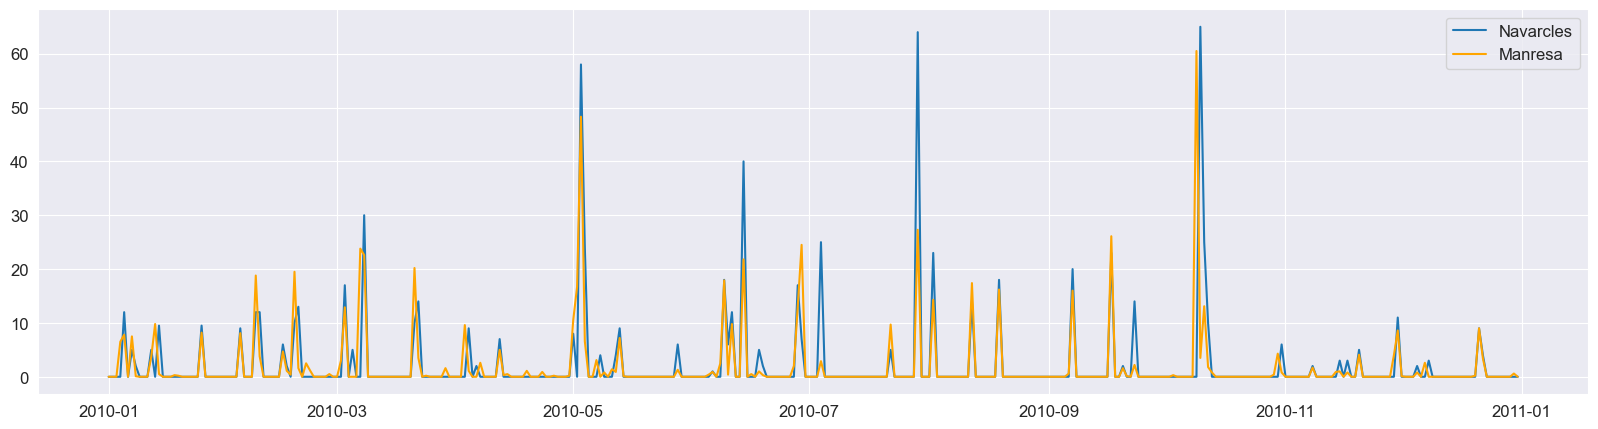

In [20]:
# TimeSeries plot
plt.figure(figsize=(20,5))
plt.plot(df['2010':'2010'], label='Navarcles')
plt.plot(df_manresa[['rainfall']]['2010':'2010'], label='Manresa', color='orange')
plt.legend()
plt.show()

### Missing values

In [22]:
res = df[df['rainfall'].isna()]
res.groupby([res.index.year, res.index.month]).sum()

rainfall
full_date full_date          
1996      2               0.0
          3               0.0
          5               0.0
2000      11              0.0
          12              0.0
2002      11              0.0
          12              0.0
2003      1               0.0
          2               0.0
          3               0.0
2016      11              0.0
          12              0.0
2017      1               0.0
          2               0.0
          3               0.0
          4               0.0
          5               0.0
          6               0.0
          7               0.0
          8               0.0
          9               0.0
          10              0.0
          11              0.0

In [23]:
df = df.fillna(df_manresa[['rainfall']])
print(df.info())
print()
print('\033[1mPercentage of NaN\033[0m')
print(f'{df["rainfall"].isna().mean():.2%}')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10958 entries, 1995-01-01 to 2024-12-31
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   rainfall  10958 non-null  float64
dtypes: float64(1)
memory usage: 429.3 KB
None

Percentage of NaN
0.00%


In [24]:
df_manresa.loc['1996-02':'1996-03', 'rainfall'].sum() == df.loc['1996-02':'1996-03', :].sum()

rainfall    True
dtype: bool

### Save dataframe for Viz

In [50]:
snow = {'2001-12-14': [1, 'neva tot el dia, 35 cm'],
        '2004-02-16': [1, 'pluja i neu, 27 l'],
        '2004-02-17': [1, 'pluja i neu, 27 l'],
        '2006-01-27': [1, 'pluja i neu'],
        '2006-01-28': [1, 'continua nevant, 20 cm'],
        '2009-12-21': [1, 'pluja i neu'],
        '2009-12-22': [1, 'pluja i neu'],
        '2010-03-08': [1, 'nevada de 30 cm'],
        '2012-02-02': [1, '11 l en forma de neu'],
        '2018-02-28': [1, 'nevada de 10 cm'],
        '2021-01-09': [1, 'poc neu'],
        '2023-01-24': [1, 'poc neu']}

In [51]:
# dictionary into a DataFrame
df_snow = pd.DataFrame.from_dict(snow, orient='index', columns=['snow', 'comment'])

# index to datetime
df_snow.index = pd.to_datetime(df_snow.index)
df_snow

,snow,comment
2001-12-14,1,"neva tot el dia, 35 cm"
2004-02-16,1,"pluja i neu, 27 l"
2004-02-17,1,"pluja i neu, 27 l"
2006-01-27,1,pluja i neu
2006-01-28,1,"continua nevant, 20 cm"
2009-12-21,1,pluja i neu
2009-12-22,1,pluja i neu
2010-03-08,1,nevada de 30 cm
2012-02-02,1,11 l en forma de neu
2018-02-28,1,nevada de 10 cm


In [52]:
# add snow info to df
df_exp = df.merge(df_snow, how='left', left_index=True, right_index=True)


In [53]:
df_exp['snow'] = df_exp['snow'].fillna(0)
df_exp['comment'] = df_exp['comment'].fillna('')

In [57]:
df_exp.loc['2018-02', :]

,rainfall,snow,comment
full_date,,,
2018-02-01,4.0,0.0,
2018-02-02,0.0,0.0,
2018-02-03,0.0,0.0,
2018-02-04,20.0,0.0,
2018-02-05,25.0,0.0,
2018-02-06,0.0,0.0,
2018-02-07,0.0,0.0,
2018-02-08,0.0,0.0,
2018-02-09,0.0,0.0,


In [56]:
df_exp.to_csv('data_navarcles_1995-2024.csv')

### Resample

In [25]:
# resampling, rainfall per month
df_month = df.resample('MS').sum()
df_month.isna().sum()

rainfall    0
dtype: int64

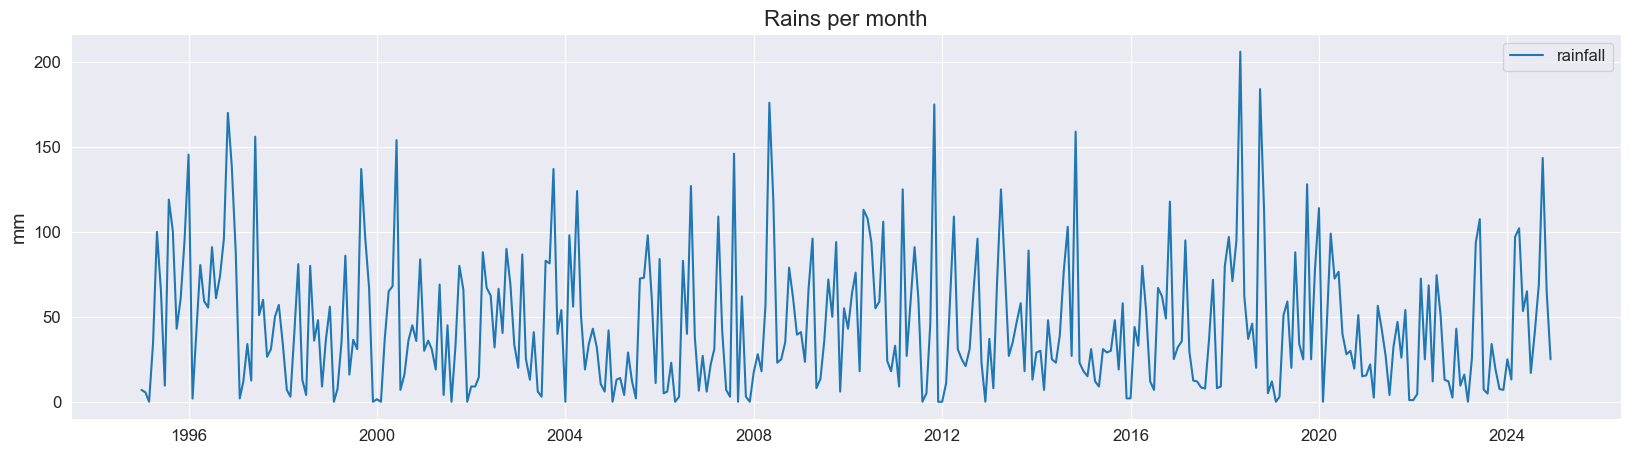

In [26]:
# TimeSeries plot
plt.figure(figsize=(20, 5))
sns.lineplot(data=df_month)
plt.title('Rains per month')
plt.ylabel('mm')
plt.xlabel(None)
plt.show()

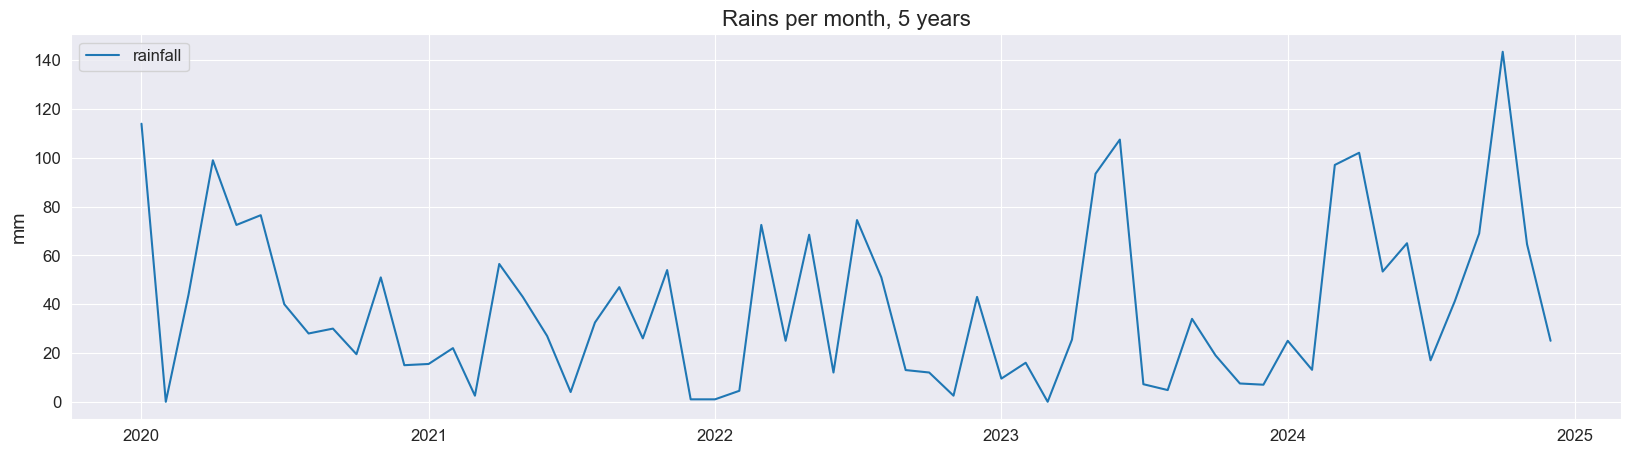

In [27]:
# TimeSeries plot
plt.figure(figsize=(20, 5))
sns.lineplot(data=df_month['2020':'2024'])
plt.title('Rains per month, 5 years')
plt.ylabel('mm')
plt.xlabel(None)
plt.show()

## EDA
### Distribution

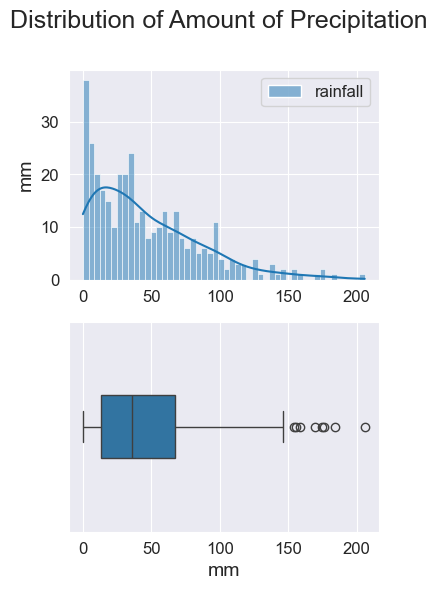

,rainfall
count,360.000000
mean,45.889444
std,39.561974
min,0.000000
25%,13.000000
50%,35.700000
75%,67.250000
max,206.000000


In [28]:
# visualizing the distribution of percipitation amount
fig, axs = plt.subplots(2, 1, figsize=(4, 6))
fig.suptitle("Distribution of Amount of Precipitation")

# histogram
(sns.histplot(data=df_month, kde=True, ax=axs[0], bins=50)
    .set(xlabel=None, ylabel='mm')
)

# boxplot
(sns.boxplot(data=df_month, ax=axs[1], width=0.3, orient='h')
    .set(yticklabels=[], xlabel='mm')
)
plt.show()

df_month.describe()

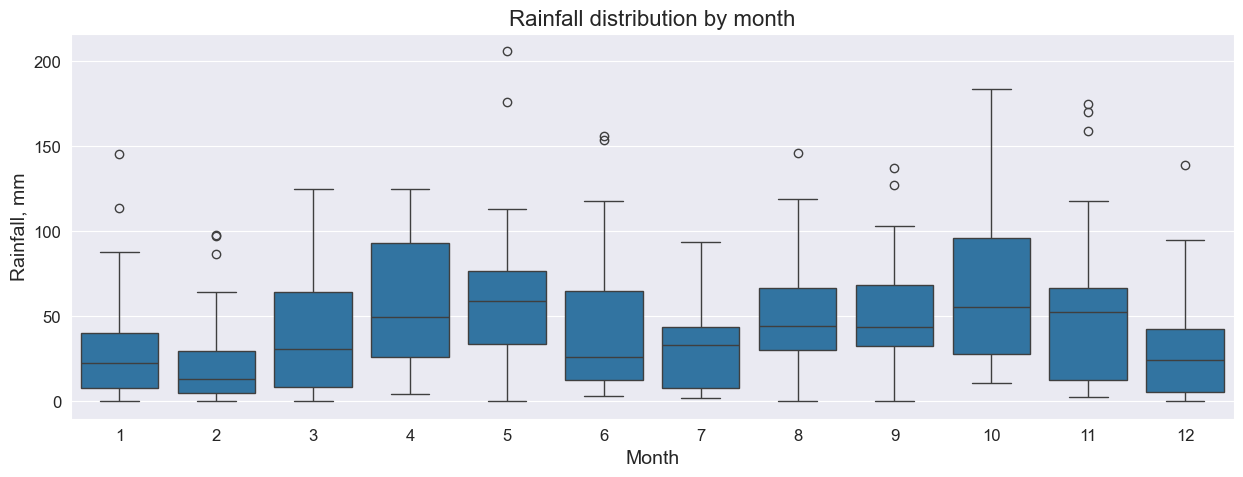

In [29]:
# rainfall distribution by month
plt.figure(figsize=(15,5))
sns.boxplot(data=df_month, x=df_month.index.month, y='rainfall')
#sns.lineplot(df_month.groupby(df_month.index.month)['rainfall'].median(), color='orange')
plt.title('Rainfall distribution by month')
plt.ylabel('Rainfall, mm')
plt.xlabel('Month')
plt.show()

In [30]:
df_month.groupby(df_month.index.month).describe()

rainfall                                                          
             count       mean        std   min     25%    50%     75%    max
full_date                                                                   
1             30.0  33.020000  36.203947   0.0   7.500  22.50  40.000  145.5
2             30.0  23.560000  28.148628   0.0   5.125  13.05  29.500   98.0
3             30.0  38.196667  33.542947   0.0   8.625  31.00  64.375  125.0
4             30.0  57.556667  37.043066   4.0  25.875  49.50  93.250  125.0
5             30.0  62.203333  45.340022   0.0  33.500  59.00  76.625  206.0
6             30.0  46.780000  44.945871   3.0  12.250  26.00  65.000  156.0
7             30.0  34.036667  28.623182   2.0   7.500  33.00  43.750   94.0
8             30.0  48.913333  32.947657   0.0  30.250  44.50  66.875  146.0
9             30.0  51.943333  33.150125   0.0  32.250  43.75  68.250  137.0
10            30.0  67.126667  44.706537  10.5  28.000  55.50  96.000  184.0
11            30.0  56.086667  49.219135   2.5  12.500  52.50  66.750  175.0
12            30.0  31.250000  33.472601   0.0   5.500  24.00  42.750  139.0

In [31]:
# outlier detection, K-Nearest Neighbors 
model_knn = KNN()
estimator_knn = model_knn.fit_predict(df_month)

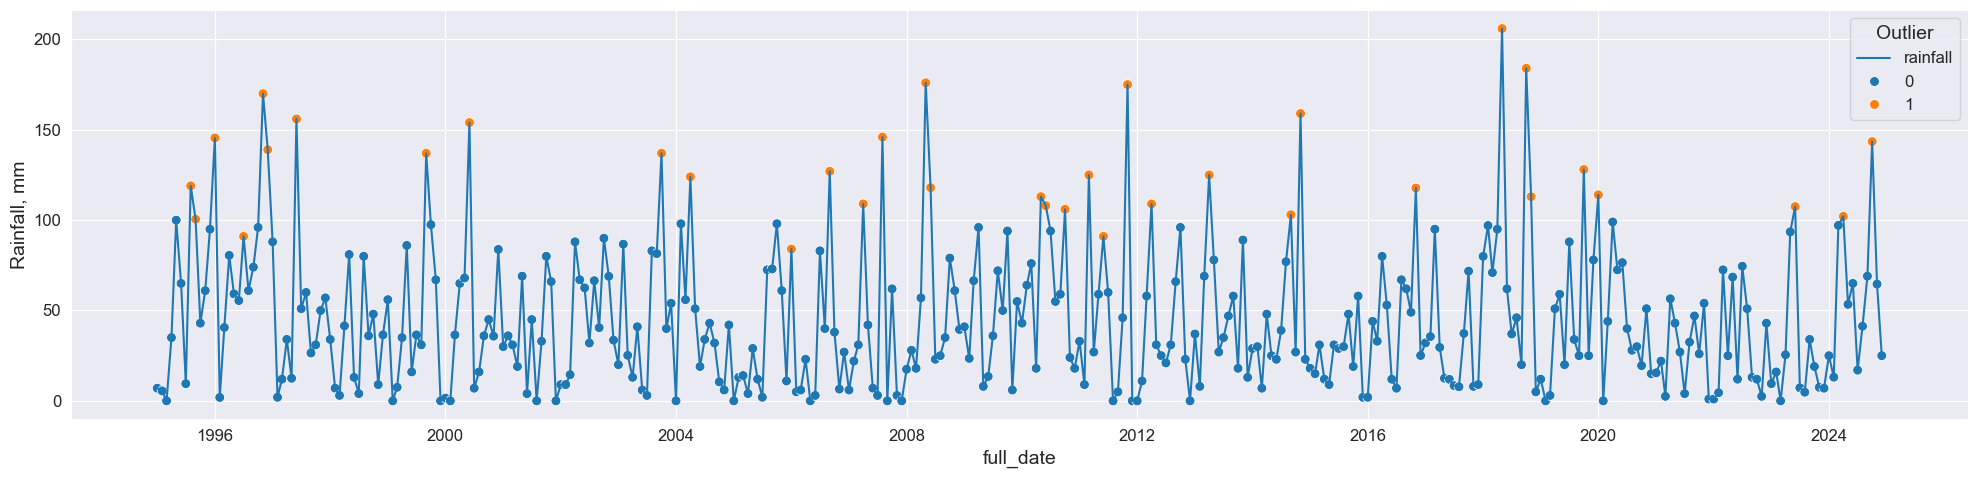

In [32]:
plt.figure(figsize=(20,5))
sns.lineplot(data=df_month)
sns.scatterplot(data = df_month, y='rainfall', x=df_month.index, s=50, hue=estimator_knn)

plt.ylabel('Rainfall, mm')
plt.legend(title='Outlier')
plt.tight_layout()
plt.show()

### Stationarity

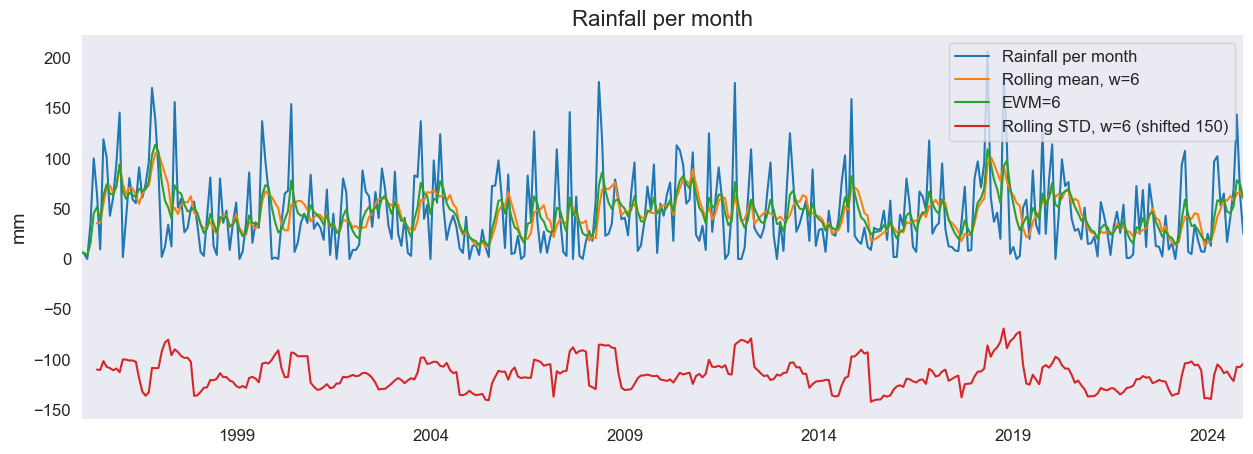

In [33]:
df_plot = df_month.copy()

# rolling mean, window size=6m
df_plot['mean'] = df_plot['rainfall'].rolling(6).mean()

# exponentially weighted moving average
df_plot['ewm'] = df_plot['rainfall'].ewm(span=6).mean()

# rolling sd, window size=6m
df_plot['std'] = df_plot['rainfall'].rolling(6).std()-150

# plot data, rolling mean and sd
df_plot.plot(figsize=(15, 5))
plt.title('Rainfall per month')
plt.ylabel('mm')
plt.legend(['Rainfall per month', 
            'Rolling mean, w=6',
            'EWM=6', 
            'Rolling STD, w=6 (shifted 150)'])

plt.xlabel(None)
plt.grid()
plt.show()

In [34]:
adf_test = adfuller(df_month['rainfall'])

print(f'ADF Statistic: {adf_test[0]}, p-value: {adf_test[1]}')
if adf_test[1] > 0.05:
    print("Data is non-stationary")
else:
    print("Data is stationary")

# remove seasonality
adf_test = adfuller(df_month.diff(12).dropna())
print('\nSeasonal differencing (lag=12 months)')
print(f'ADF Statistic: {adf_test[0]}, p-value: {adf_test[1]}')
if adf_test[1] > 0.05:
    print("Data is non-stationary")
else:
    print("Data is stationary")

ADF Statistic: -15.62857288838597, p-value: 1.6966264846974422e-28
Data is stationary

Seasonal differencing (lag=12 months)
ADF Statistic: -8.347217902607715, p-value: 3.0623327078928513e-13
Data is stationary


ADF test p-value (1.69e-28) is very small, meaning monthly rainfall data is stationary, even before applying any transformations like differencing.

ADF test for differenced time series has p-value = 3.06e-13, meaning differenced time series is stationary and confirming that applying seasonal differencing (lag=12 months) futhure removed non-stationarity.

### Seasonality

In [35]:
# decomposition of Time Series, seasonality and trend
decomposed = seasonal_decompose(df_month)

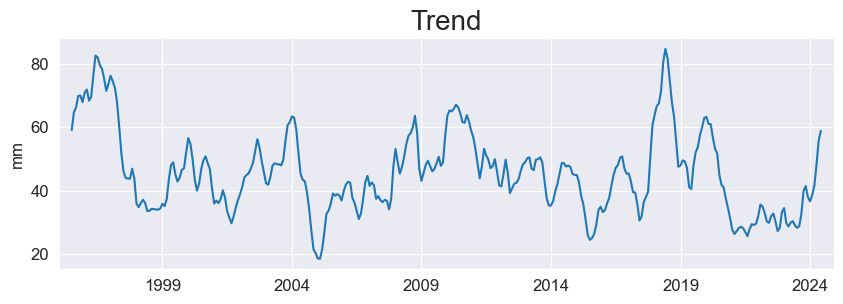

In [36]:
# plot trend
decomposed.trend.plot(figsize=(10, 3))
plt.title('Trend', fontsize=20)
plt.ylabel('mm', fontsize=12)
plt.xlabel(None)
plt.show()

mirar picos, rolling median

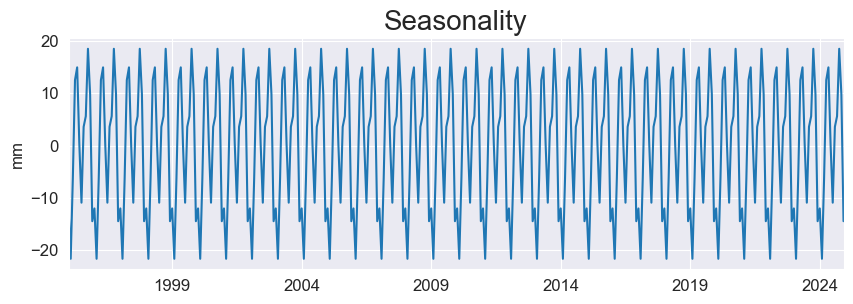

In [37]:
# plot seasonality
decomposed.seasonal.plot(figsize=(10, 3))
plt.title('Seasonality', fontsize=20)
plt.ylabel('mm', fontsize=12)
plt.xlabel(None)
plt.show()

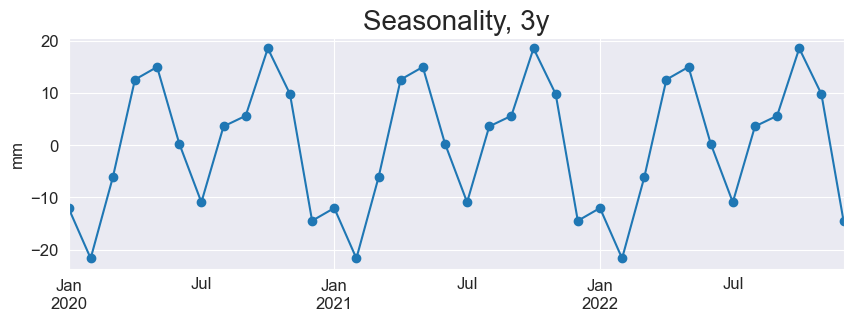

In [38]:
# plot seasonality
decomposed.seasonal['2020-01-01':'2022-12-31'].plot(style='-o', figsize=(10, 3))
plt.title('Seasonality, 3y', fontsize=20)
plt.ylabel('mm', fontsize=12)
plt.xlabel(None)
plt.show()

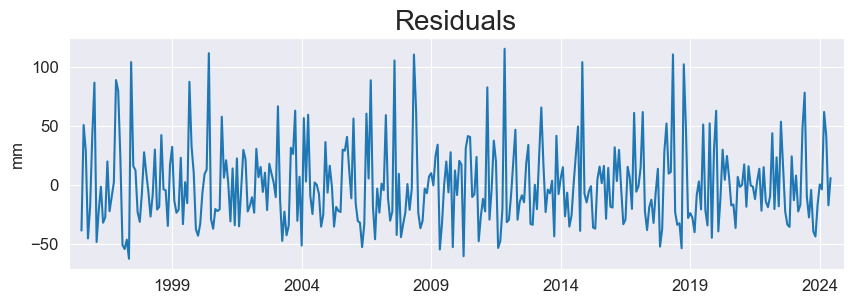

In [39]:
# plot residuals
decomposed.resid.plot(figsize=(10, 3))
plt.title('Residuals', fontsize=20)
plt.ylabel('mm', fontsize=12)
plt.xlabel(None)
plt.show()

#### ACF/PACF

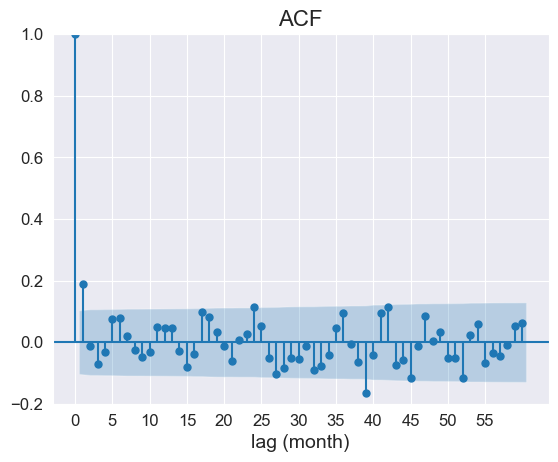

In [40]:
# plot autocorrelation function
plot_acf(df_month, lags=60)
plt.xticks(range(0, 60, 5))
plt.ylim(-0.2, 1)
plt.title('ACF')
plt.xlabel('lag (month)')
plt.show()

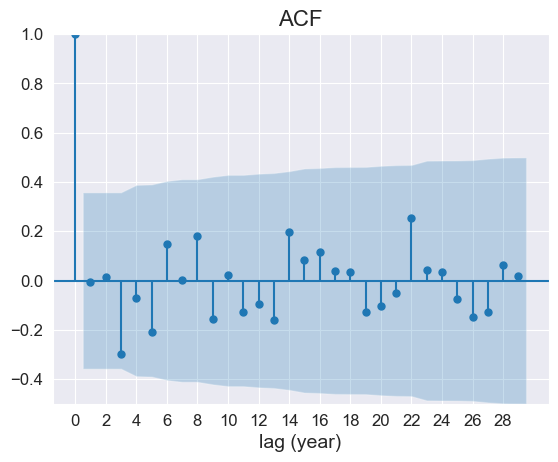

In [41]:
# resampling, rainfall per year
df_year = df.resample('1Y').sum()

# plot autocorrelation function
plot_acf(df_year, lags=29)
plt.xticks(range(0, 30, 2))
plt.ylim(-0.5, 1)
plt.title('ACF')
plt.xlabel('lag (year)')
plt.show()

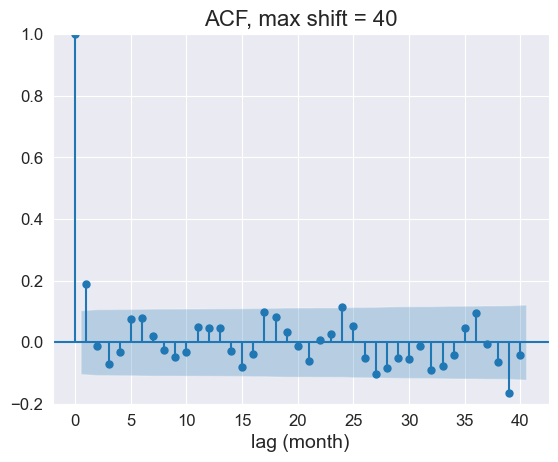

In [42]:
# plot autocorrelation function
plot_acf(df_month, lags=40)
plt.ylim(-0.2, 1)
plt.title('ACF, max shift = 40')
plt.xlabel('lag (month)')
plt.show()

Significant correlation (0.2) at lag 1 (and then decays quickly).
Then there is also significant correlation after lag 1: lag 24 (0.15) and lag 39 (-0.2).
This suggests a short-term correlation (lag 1) and a possible long-term seasonal effect (q = 1, first-order MA model).

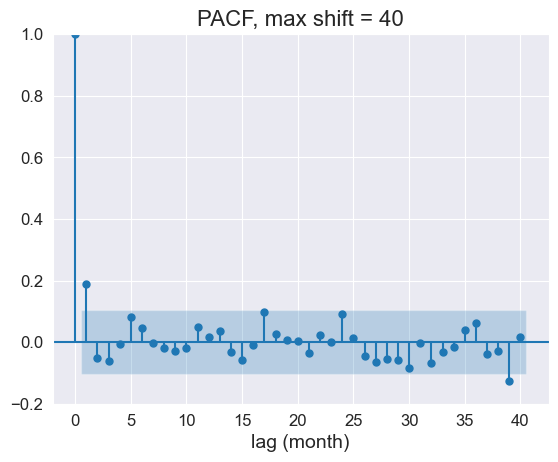

In [43]:
# plot partial autocorrelation function 
plot_pacf(df_month, lags=40)
plt.ylim(-0.2, 1)
plt.title('PACF, max shift = 40')
plt.xlabel('lag (month)')
plt.show()

Significant correlation at lag1 (and then decays quickly): This suggests an AR(1) model.
There id also significant correlation at lag 39 (-0.15).
A strong lag1 suggests a first-order autoregressive term (p = 1).

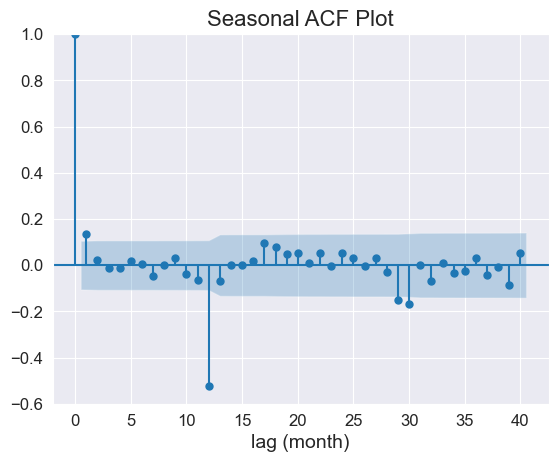

In [44]:
# seasonal differencing
df_seasonal_diff = df_month.diff(12).dropna()

# plot autocorrelation function
plot_acf(df_seasonal_diff, lags=40)
plt.ylim(-0.6, 1)
plt.xlabel('lag (month)')
plt.title('Seasonal ACF Plot')
plt.show()

Significant correlation at lag1 (0.17), significant negative spike at lag12 (-0.6) (seasonal period of 12 months), lag29 and lag30 (both around -0.2).
Lag12 is strong, suggesting a seasonal MA component (Q = 1).

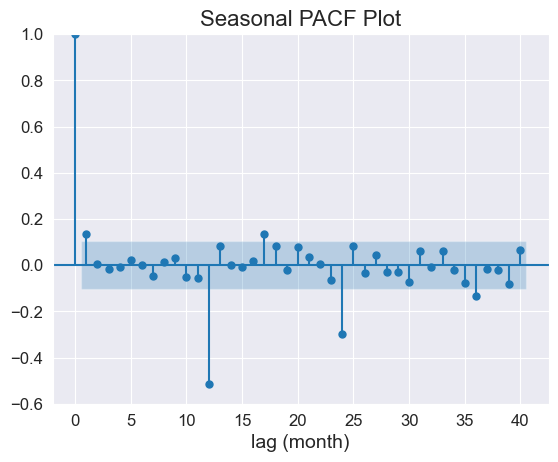

In [45]:
# plot partial autocorrelation function 
plot_pacf(df_seasonal_diff, lags=40)
plt.ylim(-0.6, 1)
plt.xlabel('lag (month)')
plt.title('Seasonal PACF Plot')
plt.show()

Significant correlation at lag1 (0.17) and lag17 (0.16). Significant negative spike at lag12 (-0.55) (seasonal period of 12 months), lag24 (-0.3) and lag36 (around -0.15).
Strong lag12 correlation suggests a seasonal AR component (P = 1).

**Initial Differencing Values**<br>
Original monthly rainfall data is already stationary, meaning d = 0 is a good starting point.<br>
After seasonal differencing (12 months), ACF/PACF still show significant seasonal correlations. D = 1 is a good choice because seasonality was still visible after first differencing.

**AR (p) and MA (q) Orders**<br>
- p = 1 (First-order AR, based on PACF peak at lag 1)
- q = 1 (First-order MA, based on ACF peak at lag 1)

**Seasonal AR (P) and Seasonal MA (Q) Orders**<br>
- P = 1 (Seasonal AR at lag 12)
- Q = 1 (Seasonal MA at lag 12)
- s = 12 (Periodicity of 12 months)

From ACF/PACF and stationarity tests, a reasonable starting SARIMA model is:<br>
SARIMA(p,d,q)(P,D,Q,s):<br>
SARIMA(1,0,1)(1,1,1,12)

## Modeling
### Train/Validation/Test split

In [46]:
# train-test split, 10% as test set
test_size = int(len(df_month) * 0.1)
test_size

36

In [47]:
train, test = df_month.iloc[:-test_size], df_month.iloc[-test_size:]

print('Train:', train.index.min(), ':', train.index.max())
print('Test:', test.index.min(), ':', test.index.max())

Train: 1995-01-01 00:00:00 : 2021-12-01 00:00:00
Test: 2022-01-01 00:00:00 : 2024-12-01 00:00:00


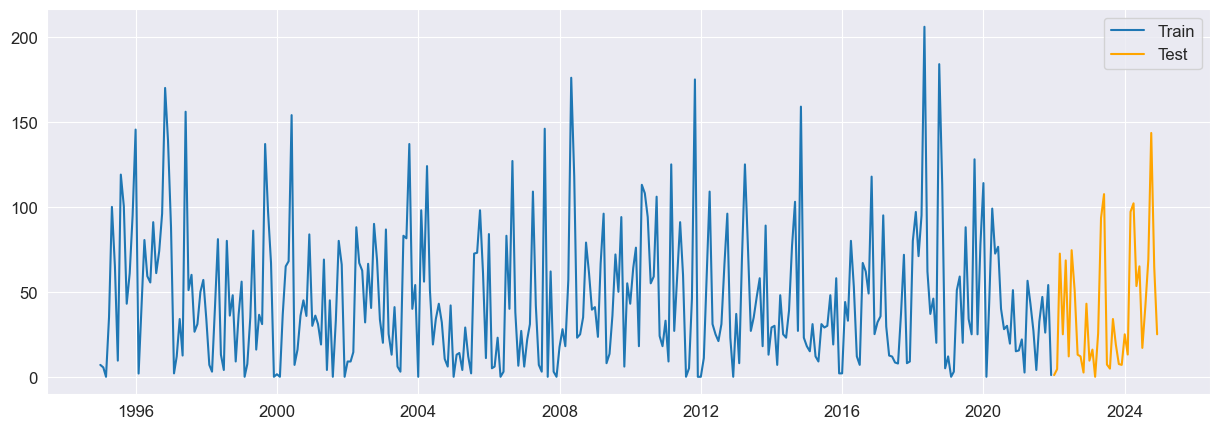

In [48]:
# plot train/test
plt.figure(figsize=(15,5))
plt.plot(train, label="Train")
plt.plot(test, label="Test", color='orange')
plt.legend()
plt.show()

In [49]:
# splits for cross-validation (8 folds)
tscv = TimeSeriesSplit(n_splits=8)

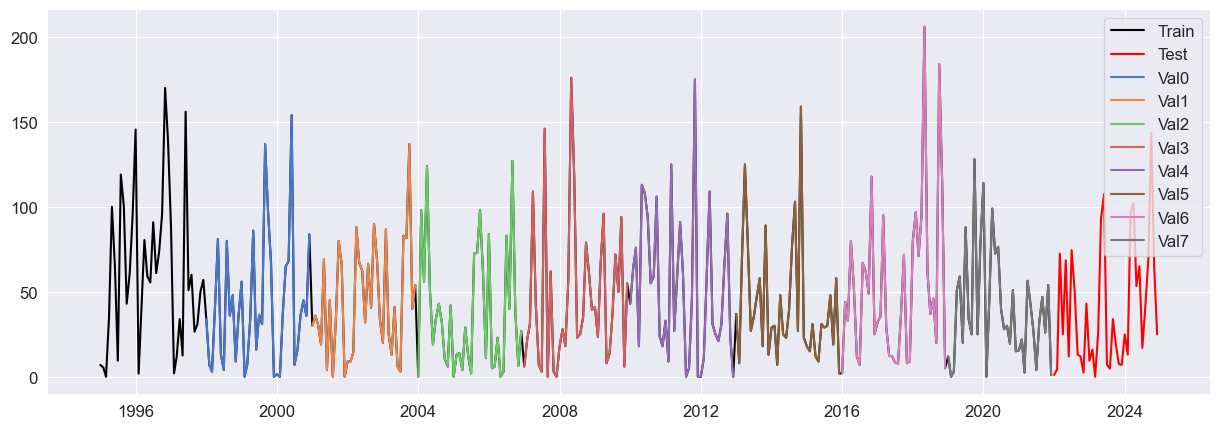

In [50]:
# plot splits for CV
plt.figure(figsize=(15,5))
plt.plot(train, label="Train", color='black')
plt.plot(test, label="Test", color='red')

for i, (train_idx, val_idx) in enumerate(tscv.split(train)):
    val_train, val_test = train.iloc[train_idx], train.iloc[val_idx]
    plt.plot(val_test, label=f"Val{i}", color=sns.color_palette('muted')[i])

plt.legend()
plt.show()

### Constant Model

make "predictions" using the median model

In [51]:
# cross-validation
mae_list = []
for train_idx, val_idx in tscv.split(train):
    val_train, val_test = train.iloc[train_idx], train.iloc[val_idx]

    # median rainfall for each month of training data
    monthly_medians = val_train.groupby(val_train.index.month)['rainfall'].median()
    
    # calculate medians
    val_test['month'] = val_test.index.month
    val_test['forecast'] = val_test['month'].map(monthly_medians)
    
    # compute MAE
    mae = mean_absolute_error(val_test['rainfall'], val_test['forecast'])
    mae_list.append(mae)
    print(f'Fold MAE: {mae}')

# average MAE across folds
avg_mae = np.mean(mae_list)
sd_mae = np.std(mae_list)
print(f'Average Cross-Validation MAE: {avg_mae:.2f}, SD: {sd_mae:.2f}')

Fold MAE: 31.98055555555556
Fold MAE: 28.61944444444445
Fold MAE: 34.31944444444444
Fold MAE: 30.599999999999998
Fold MAE: 36.519444444444446
Fold MAE: 25.30972222222222
Fold MAE: 34.08888888888889
Fold MAE: 24.005555555555553
Average Cross-Validation MAE: 30.68, SD: 4.16


add dif in %, add sd

In [52]:
constant = pd.DataFrame(data={'rainfall': val_test['rainfall'], 'forecast': val_test['forecast']})

### SARIMA

In [53]:
# cross-validation
mae_list = []
for train_idx, val_idx in tscv.split(train):
    val_train, val_test = train.iloc[train_idx], train.iloc[val_idx]
    
    # fit SARIMA model on train set
    sarima_model = SARIMAX(val_train, order=(1,0,1), seasonal_order=(1,1,1,12))
    result = sarima_model.fit(disp=False)
    
    # forecast validation period
    val_forecast = result.forecast(steps=len(val_test))
    
    # compute MAE
    mae = mean_absolute_error(val_test, val_forecast)
    mae_list.append(mae)
    print(f'Fold MAE: {mae}')

# average MAE across folds
avg_mae = np.mean(mae_list)
sd_mae = np.std(mae_list)
print(f'Average Cross-Validation MAE: {avg_mae:.2f}, SD: {sd_mae:.2f}')

Fold MAE: 51.90058406891772
Fold MAE: 28.4144997163978
Fold MAE: 32.886975616797244
Fold MAE: 29.506618398323198
Fold MAE: 34.33869497252752
Fold MAE: 25.88878167376934
Fold MAE: 33.76506200222345
Fold MAE: 25.67314271773841
Average Cross-Validation MAE: 32.80, SD: 7.88


#### Auto-ARIMA

In [54]:
# fit AutoARIMA on training data
auto_model = auto_arima(train,
                        seasonal=True, m=12,
                        stepwise=True, trace=True,
                        n_jobs=-1, suppress_warnings=True
                       )

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=3308.921, Time=3.78 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=3310.459, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=3304.183, Time=1.25 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=3303.880, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3588.119, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=3302.193, Time=0.23 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=3303.810, Time=0.25 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=3300.877, Time=1.96 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=3301.142, Time=3.55 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=3301.525, Time=3.99 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=3301.257, Time=1.91 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=3301.246, Time=2.30 sec
 ARIMA(0,0,1)(2,0,2)[12] intercept   : AIC=3303.504, Time=5.42 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=3307.141, Time=1.72 sec
 ARIMA(1,0,1)(1,0,1

In [55]:
# fit the SARIMAX model with the selected orders
# cross-validation
mae_list = []
for train_idx, val_idx in tscv.split(train):
    val_train, val_test = train.iloc[train_idx], train.iloc[val_idx]
    
    # fit SARIMA model on train set
    sarima_model = SARIMAX(val_train, order=auto_model.order, seasonal_order=auto_model.seasonal_order)
    result = sarima_model.fit(disp=False)
    
    # forecast validation period
    val_forecast = result.forecast(steps=len(val_test))
    
    # compute MAE
    mae = mean_absolute_error(val_test, val_forecast)
    mae_list.append(mae)
    print(f'Fold MAE: {mae}')

# average MAE across folds
avg_mae = np.mean(mae_list)
sd_mae = np.std(mae_list)
print(f'Average Cross-Validation MAE: {avg_mae:.2f}, SD: {sd_mae:.2f}')

Fold MAE: 28.380119343864077
Fold MAE: 27.635788151207763
Fold MAE: 32.25316259007673
Fold MAE: 29.137334799390032
Fold MAE: 34.66430301749337
Fold MAE: 24.890560528319227
Fold MAE: 32.83152774236536
Fold MAE: 24.995622522993237
Average Cross-Validation MAE: 29.35, SD: 3.38


In [56]:
sarima_1 = pd.DataFrame(data={'rainfall': val_test['rainfall'], 'forecast': val_forecast})

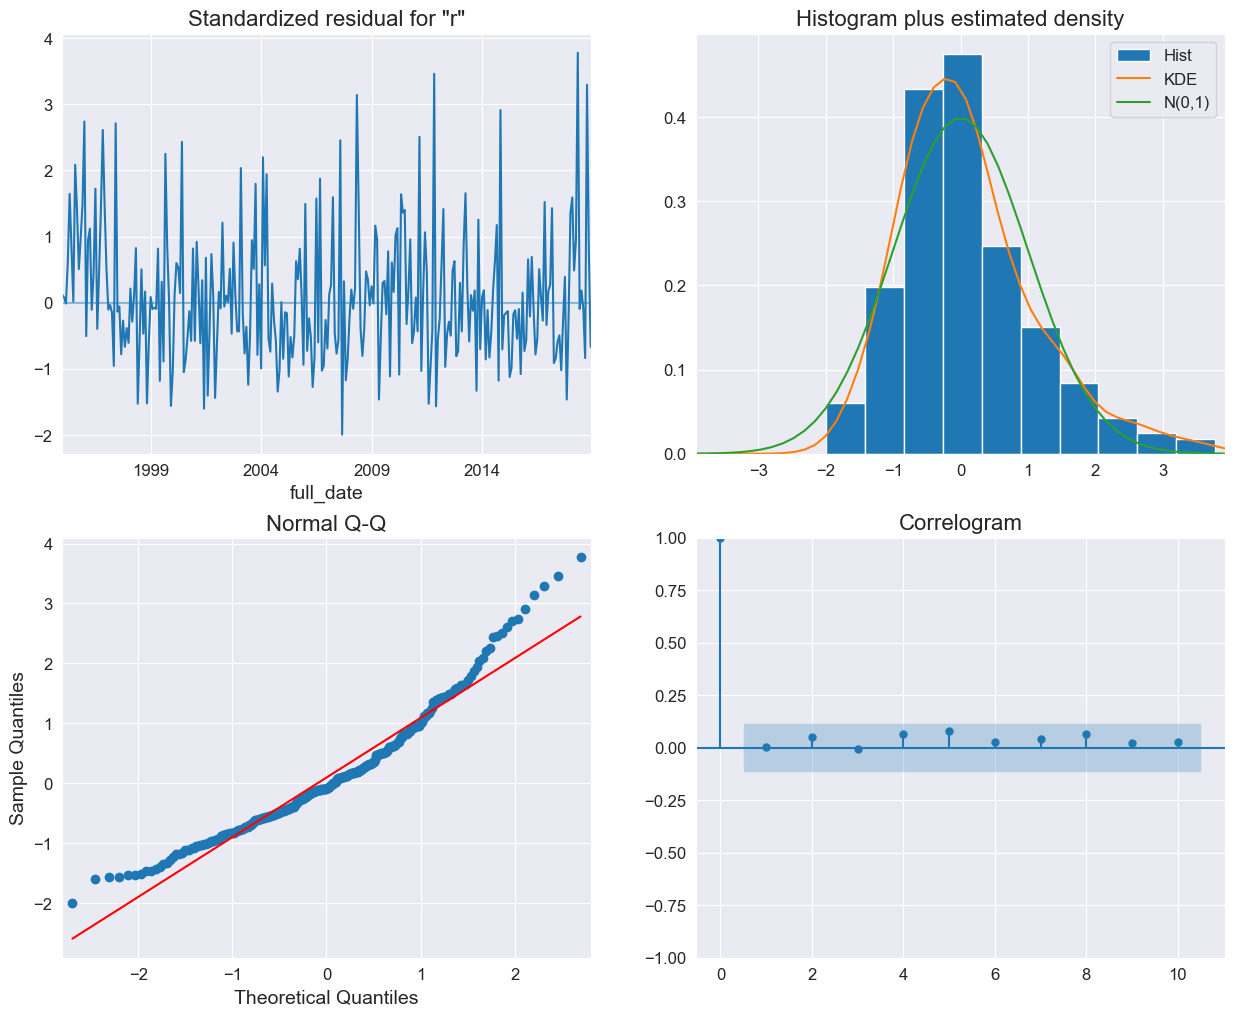

In [57]:
result.plot_diagnostics(figsize=(15,12))
plt.show()

**Standardized residual**<br>
The Standardized residual is consistent across the graph, meaning that the data is close to being stationary.

**Histogram plus KDE estimate**<br>
The KDE curve is similar to the normal distribution.

**Normal Q-Q**<br>
The data points are clustered close to the line.<br>

**Correlogram (ACF plot)** <br>
All values fall within the 95% confidence interval (adding the seasonality component)

#### Auto-ARIMA with External Features

In [58]:
# number of rainy days per month
df_month['n_rainy_days'] = df.resample('MS')['rainfall'].apply(lambda x: (x > 0).sum())

In [59]:
# number of onsecutive rainy/dry days
def count_consecutive_days(series):
    max_streak = 0
    current_streak = 0
    for val in series:
        if val > 0:
            current_streak += 1
            max_streak = max(max_streak, current_streak)
        else:
            current_streak = 0
    return max_streak

df_month['cnstv_rainy_days'] = df.resample('MS')['rainfall'].apply(count_consecutive_days)

df_month['cnstv_dry_days'] = df.resample('MS')['rainfall'].apply(lambda x: count_consecutive_days(x == 0))

In [60]:
# generate additional features
def make_features(data, target, lags, rolling_size):
 
    data['month'] = data.index.month   
    
    for lag in lags:
        data[f'lag_{lag}'] = data[target].shift(lag)
    
    data['rolling_mean'] = data[target].rolling(rolling_size).mean()
    data['rolling_std'] = data[target].rolling(rolling_size).std()
    
    return(data)

In [61]:
# adding the new features
df_month = make_features(df_month, 'rainfall', [1, 2, 3, 12], 12)
df_month

,rainfall,n_rainy_days,cnstv_rainy_days,cnstv_dry_days,month,lag_1,lag_2,lag_3,lag_12,rolling_mean,rolling_std
full_date,,,,,,,,,,,
1995-01-01,7.0,1,1,17,1,NaN,NaN,NaN,NaN,NaN,NaN
1995-02-01,5.5,1,1,21,2,7.0,NaN,NaN,NaN,NaN,NaN
1995-03-01,0.0,0,0,31,3,5.5,7.0,NaN,NaN,NaN,NaN
1995-04-01,35.0,4,2,20,4,0.0,5.5,7.0,NaN,NaN,NaN
1995-05-01,100.0,6,3,8,5,35.0,0.0,5.5,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,41.3,4,1,13,8,17.0,65.0,53.4,4.8,40.125000,33.060196
2024-09-01,69.0,9,2,9,9,41.3,17.0,65.0,34.0,43.041667,34.001215
2024-10-01,143.5,11,5,7,10,69.0,41.3,17.0,19.0,53.416667,43.629740


In [66]:
df_month.isna().sum()

rainfall             0
n_rainy_days         0
cnstv_rainy_days     0
cnstv_dry_days       0
month                0
lag_1                1
lag_2                2
lag_3                3
lag_12              12
rolling_mean        11
rolling_std         11
dtype: int64

In [79]:
train, test = df_month.iloc[:-test_size], df_month.iloc[-test_size:]

print('Train:', train.index.min(), ':', train.index.max())
print('Test:', test.index.min(), ':', test.index.max())

Train: 1995-01-01 00:00:00 : 2021-12-01 00:00:00
Test: 2022-01-01 00:00:00 : 2024-12-01 00:00:00


In [80]:
train = train.fillna(0)
train.head(13)

,rainfall,n_rainy_days,cnstv_rainy_days,cnstv_dry_days,month,lag_1,lag_2,lag_3,lag_12,rolling_mean,rolling_std
full_date,,,,,,,,,,,
1995-01-01,7.0,1,1,17,1,0.0,0.0,0.0,0.0,0.000000,0.000000
1995-02-01,5.5,1,1,21,2,7.0,0.0,0.0,0.0,0.000000,0.000000
1995-03-01,0.0,0,0,31,3,5.5,7.0,0.0,0.0,0.000000,0.000000
1995-04-01,35.0,4,2,20,4,0.0,5.5,7.0,0.0,0.000000,0.000000
1995-05-01,100.0,6,3,8,5,35.0,0.0,5.5,0.0,0.000000,0.000000
1995-06-01,65.0,7,2,8,6,100.0,35.0,0.0,0.0,0.000000,0.000000
1995-07-01,9.5,2,1,25,7,65.0,100.0,35.0,0.0,0.000000,0.000000
1995-08-01,119.0,8,2,7,8,9.5,65.0,100.0,0.0,0.000000,0.000000
1995-09-01,100.5,6,2,7,9,119.0,9.5,65.0,0.0,0.000000,0.000000


In [73]:
# define external features
exo_features =  ['n_rainy_days', 'cnstv_rainy_days', 'cnstv_dry_days', 'month',
                 'lag_1', 'lag_2', 'lag_3', 'lag_12',
                 'rolling_mean', 'rolling_std']

In [74]:
# fit AutoARIMA on training data
auto_model = auto_arima(train['rainfall'],
                        exogenous=train[exo_features],
                        seasonal=True, m=12,
                        stepwise=True, trace=True,
                        n_jobs=-1, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=3308.921, Time=3.47 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=3310.459, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=3304.183, Time=0.93 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=3303.880, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3588.119, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=3302.193, Time=0.19 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=3303.810, Time=0.26 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=3300.877, Time=2.11 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=3301.142, Time=3.65 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=3301.525, Time=4.07 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=3301.257, Time=2.20 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=3301.246, Time=2.49 sec
 ARIMA(0,0,1)(2,0,2)[12] intercept   : AIC=3303.504, Time=5.53 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=3307.141, Time=1.93 sec
 ARIMA(1,0,1)(1,0,1

In [81]:
# fit the SARIMAX model with the selected orders
# cross-validation
mae_list = []
for train_idx, val_idx in tscv.split(train):
    val_train, val_test = train.iloc[train_idx], train.iloc[val_idx]
    
    # fit SARIMA model on train set
    sarima_model = SARIMAX(val_train['rainfall'], 
                           exog=val_train[exo_features],
                           order=auto_model.order, 
                           seasonal_order=auto_model.seasonal_order)
    
    result = sarima_model.fit(disp=False)
    
    # forecast validation period
    val_forecast = result.forecast(steps=len(val_test),
                                   exog=val_test[exo_features])
    
    # compute MAE
    mae = mean_absolute_error(val_test['rainfall'], val_forecast)
    mae_list.append(mae)
    print(f'Fold MAE: {mae}')

# average MAE across folds
avg_mae = np.mean(mae_list)
sd_mae = np.std(mae_list)
print(f'Average Cross-Validation MAE: {avg_mae:.2f}, SD: {sd_mae:.2f}')

Fold MAE: 23.222253153004875
Fold MAE: 22.96946445201108
Fold MAE: 20.76793728494542
Fold MAE: 17.07230410472223
Fold MAE: 21.323275496627723
Fold MAE: 20.016710686560664
Fold MAE: 30.29900273318431
Fold MAE: 21.449486221430693
Average Cross-Validation MAE: 22.14, SD: 3.56


In [82]:
sarima_2 = pd.DataFrame(data={'rainfall': val_test['rainfall'], 'forecast': val_forecast})

### Prophet

In [83]:
# convert data to Prophet format
train_prophet = train[['rainfall']].reset_index().rename(columns={'full_date': 'ds', 'rainfall': 'y'})

In [86]:
# fit Prophet model
# cross-validation
mae_list = []
for train_idx, val_idx in tscv.split(train_prophet):
    val_train, val_test = train_prophet.iloc[train_idx], train_prophet.iloc[val_idx]
    
    # fit model on train set
    model = Prophet(yearly_seasonality=True, 
                    seasonality_mode="multiplicative"
                   )
    
    model.fit(val_train)
    
    # forecast future values for validation period
    future = val_test[['ds']]        # validation timestamps
    forecast = model.predict(future)

    # Compute MAE for this fold
    mae = mean_absolute_error(val_test['y'], forecast['yhat'])
    mae_list.append(mae)
    print(f'Fold MAE: {mae:.2f}')

# average MAE across folds
avg_mae = np.mean(mae_list)
sd_mae = np.std(mae_list)
print(f'Average Cross-Validation MAE: {avg_mae:.2f}, SD: {sd_mae:.2f}')

22:13:14 - cmdstanpy - INFO - Chain [1] start processing
22:13:14 - cmdstanpy - INFO - Chain [1] done processing
22:13:15 - cmdstanpy - INFO - Chain [1] start processing


Fold MAE: 31.25


22:13:15 - cmdstanpy - INFO - Chain [1] done processing
22:13:15 - cmdstanpy - INFO - Chain [1] start processing
22:13:15 - cmdstanpy - INFO - Chain [1] done processing


Fold MAE: 27.79
Fold MAE: 28.53


22:13:15 - cmdstanpy - INFO - Chain [1] start processing
22:13:15 - cmdstanpy - INFO - Chain [1] done processing
22:13:16 - cmdstanpy - INFO - Chain [1] start processing
22:13:16 - cmdstanpy - INFO - Chain [1] done processing


Fold MAE: 31.35
Fold MAE: 34.90


22:13:16 - cmdstanpy - INFO - Chain [1] start processing
22:13:16 - cmdstanpy - INFO - Chain [1] done processing
22:13:16 - cmdstanpy - INFO - Chain [1] start processing
22:13:16 - cmdstanpy - INFO - Chain [1] done processing


Fold MAE: 24.38


22:13:16 - cmdstanpy - INFO - Chain [1] start processing
22:13:16 - cmdstanpy - INFO - Chain [1] done processing


Fold MAE: 33.59
Fold MAE: 25.95
Average Cross-Validation MAE: 29.72, SD: 3.44


In [87]:
prophet = pd.DataFrame(data={'rainfall': val_test.set_index('ds')['y'], 
                             'forecast': forecast.set_index('ds')['yhat']})

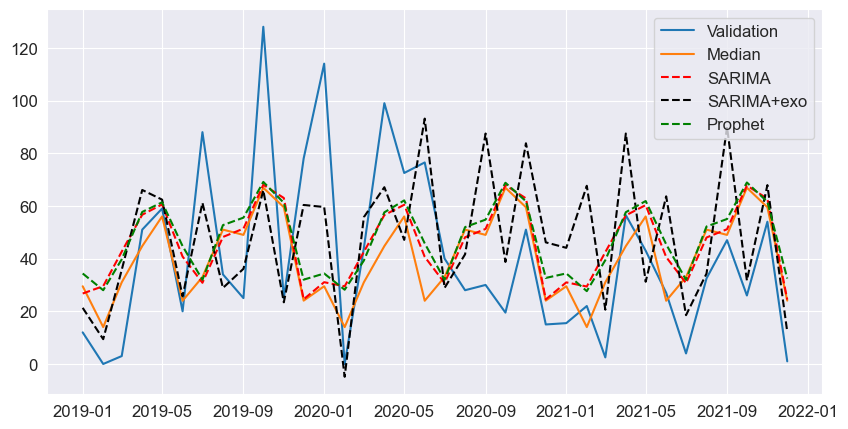

In [89]:
# plot predictions
plt.figure(figsize=(10,5))
plt.plot(constant, label=['Validation', 'Median'])
plt.plot(sarima_1['forecast'], label="SARIMA", linestyle='dashed', color='red')
plt.plot(sarima_2['forecast'], label="SARIMA+exo", linestyle='dashed', color='black')
plt.plot(prophet['forecast'], label="Prophet", linestyle='dashed', color='green')
plt.legend()
plt.show()

### Classic models

In [91]:
df_added = df_month.fillna(0)
df_added.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 360 entries, 1995-01-01 to 2024-12-01
Freq: MS
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rainfall          360 non-null    float64
 1   n_rainy_days      360 non-null    int64  
 2   cnstv_rainy_days  360 non-null    int64  
 3   cnstv_dry_days    360 non-null    int64  
 4   month             360 non-null    int32  
 5   lag_1             360 non-null    float64
 6   lag_2             360 non-null    float64
 7   lag_3             360 non-null    float64
 8   lag_12            360 non-null    float64
 9   rolling_mean      360 non-null    float64
 10  rolling_std       360 non-null    float64
dtypes: float64(7), int32(1), int64(3)
memory usage: 40.4 KB


In [92]:
df_added = df_added.merge(
    df_manresa_month[['t_max', 't_min', 'insolation']], how='left', 
    left_index=True, right_index=True
)
df_added.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 360 entries, 1995-01-01 to 2024-12-01
Freq: MS
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rainfall          360 non-null    float64
 1   n_rainy_days      360 non-null    int64  
 2   cnstv_rainy_days  360 non-null    int64  
 3   cnstv_dry_days    360 non-null    int64  
 4   month             360 non-null    int32  
 5   lag_1             360 non-null    float64
 6   lag_2             360 non-null    float64
 7   lag_3             360 non-null    float64
 8   lag_12            360 non-null    float64
 9   rolling_mean      360 non-null    float64
 10  rolling_std       360 non-null    float64
 11  t_max             348 non-null    float64
 12  t_min             348 non-null    float64
 13  insolation        348 non-null    float64
dtypes: float64(10), int32(1), int64(3)
memory usage: 48.9 KB


In [93]:
df_added = df_added.fillna(0)

In [94]:
# target and features
y = df_added['rainfall']
X = df_added.drop('rainfall', axis=1)

In [95]:
# train-test split, 10% as test set
test_size = int(len(df_added) * 0.1)
test_size

36

In [96]:
X_train, x_test = X.iloc[:-test_size], X.iloc[-test_size:]
y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]

In [97]:
print('Train:', X_train.index.min(), ':', X_train.index.max())
print('Test:', y_test.index.min(), ':', y_test.index.max())

Train: 1995-01-01 00:00:00 : 2021-12-01 00:00:00
Test: 2022-01-01 00:00:00 : 2024-12-01 00:00:00


In [98]:
# splits for cross-validation (8 folds)
tscv = TimeSeriesSplit(n_splits=8)

In [99]:
for train_idx, val_idx in tscv.split(X_train):
    print(len(train_idx), len(train.iloc[val_idx]))

36 36
72 36
108 36
144 36
180 36
216 36
252 36
288 36


In [102]:
# create the pipeline
pipeline = Pipeline([('regr', DummyRegressor())])

In [103]:
# set grid search params
params = [
    {'regr': [ElasticNet(random_state=RANDOM_STATE)],
     'regr__l1_ratio': [0, 0.5, 1]},
    
    {'regr': [LGBMRegressor(random_state=RANDOM_STATE, verbose=-1)],
     'regr__n_estimators': range(20, 200, 10),
     'regr__max_depth': range(4, 12),
     'regr__num_leaves': range(35, 150),
     'regr__learning_rate': [0.01, 0.1, 0.3]}, 
       
    {'regr': [CatBoostRegressor(random_state=RANDOM_STATE, silent=True)],
     'regr__n_estimators': range(20, 200),
     'regr__depth': [4, 6, 8, 10],
     'regr__learning_rate': [0.01, 0.1, 0.3],
     'regr__l2_leaf_reg': [0.2, 0.5, 1, 3]}]

In [104]:
# construct grid search
grid = RandomizedSearchCV(pipeline,
                          params,
                          cv=tscv,
                          verbose=False,
                          scoring='neg_mean_absolute_error',
                          n_jobs=-1,
                          random_state=RANDOM_STATE)

In [105]:
# fit the grid search object
grid.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
                   estimator=Pipeline(steps=[('regr', DummyRegressor())]),
                   n_jobs=-1,
                   param_distributions=[{'regr': [ElasticNet(random_state=42)],
                                         'regr__l1_ratio': [0, 0.5, 1]},
                                        {'regr': [LGBMRegressor(random_state=42,
                                                                verbose=-1)],
                                         'regr__learning_rate': [0.01, 0.1,
                                                                 0.3],
                                         'regr__max_depth': range(4, 12),
                                         'regr__n_estimators': range(20, 200, 10),
                                         'regr__num_leaves': range(35, 150)},
                                        {'regr': [<catboost.core.CatBoostRegressor object at 0x152871210>],
                                         'regr__depth': [4, 6, 8, 10],
                                         'regr__l2_leaf_reg': [0.2, 0.5, 1, 3],
                                         'regr__learning_rate': [0.01, 0.1,
                                                                 0.3],
                                         'regr__n_estimators': range(20, 200)}],
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=False)

In [106]:
# MAE
print('MAE:', round(abs(grid.best_score_), 4))

# training time
time_fit = grid.cv_results_['mean_fit_time'][grid.best_index_]
print(f'Learning time: {time_fit:.4f} s')

# prediction time
time_pred = grid.cv_results_['mean_score_time'][grid.best_index_]
print(f'Prediction time: {time_pred:.4f} s')

MAE: 23.083
Learning time: 1.7416 s
Prediction time: 0.0081 s


In [107]:
# hyperparameters of the best model
print('Hyperparameters of the best model:')
grid.best_params_

Hyperparameters of the best model:


{'regr__n_estimators': 180,
 'regr__learning_rate': 0.1,
 'regr__l2_leaf_reg': 0.2,
 'regr__depth': 8,
 'regr': <catboost.core.CatBoostRegressor at 0x152871210>}

## Vizualizations

In [108]:
df_plot = df_month.copy()
df_plot['year'] = df_plot.index.year
df_plot['month'] = df_plot.index.month

In [110]:
# custom colormap
colors = ["#fafa6e", "#2a4858"]
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=64)

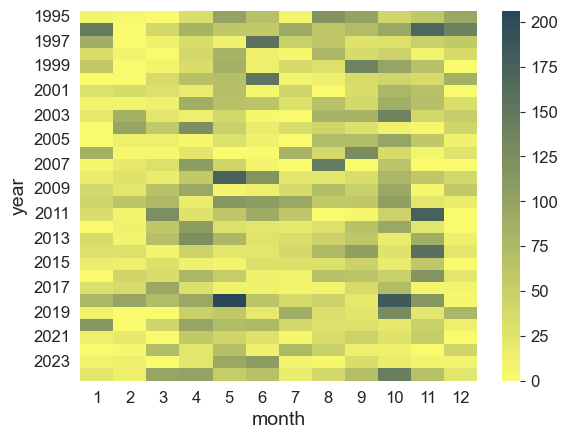

In [111]:
sns.heatmap(df_plot.pivot(index='year', columns='month', values='rainfall'),
           cmap=custom_cmap)
plt.show()